## Data

In [ ]:
!unzip /content/test.zip
!unzip /content/train.zip
!unzip /content/val.zip

Archive:  /content/test.zip
   creating: test/
Archive:  /content/train.zip
   creating: train/
  inflating: train/text0.txt         
  inflating: train/text1.txt         
  inflating: train/text10.txt        
  inflating: train/text100.txt       
  inflating: train/text1000.txt      
  inflating: train/text1001.txt      
  inflating: train/text1002.txt      
  inflating: train/text1003.txt      
  inflating: train/text1004.txt      
  inflating: train/text1005.txt      
  inflating: train/text1006.txt      
  inflating: train/text1007.txt      
  inflating: train/text1008.txt      
  inflating: train/text1009.txt      
  inflating: train/text101.txt       
  inflating: train/text1010.txt      
  inflating: train/text1011.txt      
  inflating: train/text1012.txt      
  inflating: train/text1013.txt      
  inflating: train/text1014.txt      
  inflating: train/text1015.txt      
  inflating: train/text1016.txt      
  inflating: train/text1017.txt      
  inflating: train/text1018.tx

In [ ]:
!unzip /content/out_text.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: out_text/text5499.txt   
  inflating: out_text/text55.txt     
  inflating: out_text/text550.txt    
  inflating: out_text/text5500.txt   
  inflating: out_text/text5501.txt   
  inflating: out_text/text5502.txt   
  inflating: out_text/text5503.txt   
  inflating: out_text/text5504.txt   
  inflating: out_text/text5505.txt   
  inflating: out_text/text5506.txt   
  inflating: out_text/text5507.txt   
  inflating: out_text/text5508.txt   
  inflating: out_text/text5509.txt   
  inflating: out_text/text551.txt    
  inflating: out_text/text5510.txt   
  inflating: out_text/text5511.txt   
  inflating: out_text/text5512.txt   
  inflating: out_text/text5513.txt   
  inflating: out_text/text5514.txt   
  inflating: out_text/text5515.txt   
  inflating: out_text/text5516.txt   
  inflating: out_text/text5517.txt   
  inflating: out_text/text5518.txt   
  inflating: out_text/text5519.txt   
  inflating: out_text/text552.t

In [ ]:
import shutil
import glob
files_out = glob.glob("/content/out_text/*.txt")
for file in files_out:
  shutil.copy(file, "/content/data/train")

## ProjectedAdaptiveLogSoftmax

In [ ]:
from collections import defaultdict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

CUDA_MAJOR = int(torch.version.cuda.split('.')[0])
CUDA_MINOR = int(torch.version.cuda.split('.')[1])

class ProjectedAdaptiveLogSoftmax(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1,
                 keep_order=False):
        super(ProjectedAdaptiveLogSoftmax, self).__init__()

        self.n_token = n_token
        self.d_embed = d_embed
        self.d_proj = d_proj

        self.cutoffs = cutoffs + [n_token]
        self.cutoff_ends = [0] + self.cutoffs
        self.div_val = div_val

        self.shortlist_size = self.cutoffs[0]
        self.n_clusters = len(self.cutoffs) - 1
        self.head_size = self.shortlist_size + self.n_clusters

        if self.n_clusters > 0:
            self.cluster_weight = nn.Parameter(torch.zeros(self.n_clusters, self.d_embed))
            self.cluster_bias = nn.Parameter(torch.zeros(self.n_clusters))

        self.out_layers = nn.ModuleList()
        self.out_projs = nn.ParameterList()

        if div_val == 1:
            for i in range(len(self.cutoffs)):
                if d_proj != d_embed:
                    self.out_projs.append(
                        nn.Parameter(torch.Tensor(d_proj, d_embed))
                    )
                else:
                    self.out_projs.append(None)

            self.out_layers.append(nn.Linear(d_embed, n_token))
        else:
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i+1]
                d_emb_i = d_embed // (div_val ** i)

                self.out_projs.append(
                    nn.Parameter(torch.Tensor(d_proj, d_emb_i))
                )

                self.out_layers.append(nn.Linear(d_emb_i, r_idx-l_idx))

        self.keep_order = keep_order

    def _compute_logit(self, hidden, weight, bias, proj):
        if proj is None:
            logit = F.linear(hidden, weight, bias=bias)
        else:
            # if CUDA_MAJOR <= 9 and CUDA_MINOR <= 1:
            proj_hid = F.linear(hidden, proj.t().contiguous())
            logit = F.linear(proj_hid, weight, bias=bias)
            # else:
            #     logit = torch.einsum('bd,de,ev->bv', (hidden, proj, weight.t()))
            #     if bias is not None:
            #         logit = logit + bias

        return logit

    def forward(self, hidden, target, keep_order=False):
        '''
            hidden :: [len*bsz x d_proj]
            target :: [len*bsz]
        '''

        if hidden.size(0) != target.size(0):
            raise RuntimeError('Input and target should have the same size '
                               'in the batch dimension.')

        if self.n_clusters == 0:
            logit = self._compute_logit(hidden, self.out_layers[0].weight,
                                        self.out_layers[0].bias, self.out_projs[0])
            nll = -F.log_softmax(logit, dim=-1) \
                    .gather(1, target.unsqueeze(1)).squeeze(1)
        else:
            # construct weights and biases
            weights, biases = [], []
            for i in range(len(self.cutoffs)):
                if self.div_val == 1:
                    l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]
                    weight_i = self.out_layers[0].weight[l_idx:r_idx]
                    bias_i = self.out_layers[0].bias[l_idx:r_idx]
                else:
                    weight_i = self.out_layers[i].weight
                    bias_i = self.out_layers[i].bias

                if i == 0:
                    weight_i = torch.cat(
                        [weight_i, self.cluster_weight], dim=0)
                    bias_i = torch.cat(
                        [bias_i, self.cluster_bias], dim=0)

                weights.append(weight_i)
                biases.append(bias_i)

            head_weight, head_bias, head_proj = weights[0], biases[0], self.out_projs[0]

            head_logit = self._compute_logit(hidden, head_weight, head_bias, head_proj)
            head_logprob = F.log_softmax(head_logit, dim=1)

            nll = torch.zeros_like(target,
                    dtype=hidden.dtype, device=hidden.device)

            offset = 0
            cutoff_values = [0] + self.cutoffs
            for i in range(len(cutoff_values) - 1):
                l_idx, r_idx = cutoff_values[i], cutoff_values[i + 1]

                mask_i = (target >= l_idx) & (target < r_idx)
                indices_i = mask_i.nonzero().squeeze()

                if indices_i.numel() == 0:
                    continue

                target_i = target.index_select(0, indices_i) - l_idx
                head_logprob_i = head_logprob.index_select(0, indices_i)

                if i == 0:
                    logprob_i = head_logprob_i.gather(1, target_i[:,None]).squeeze(1)
                else:
                    weight_i, bias_i, proj_i = weights[i], biases[i], self.out_projs[i]

                    hidden_i = hidden.index_select(0, indices_i)

                    tail_logit_i = self._compute_logit(hidden_i, weight_i, bias_i, proj_i)
                    tail_logprob_i = F.log_softmax(tail_logit_i, dim=1)

                    logprob_i = head_logprob_i[:, -i] \
                              + tail_logprob_i.gather(1, target_i[:,None]).squeeze(1)

                if (hasattr(self, 'keep_order') and self.keep_order) or keep_order:
                    nll.index_copy_(0, indices_i, -logprob_i)
                else:
                    nll[offset:offset+logprob_i.size(0)].copy_(-logprob_i)

                offset += logprob_i.size(0)

        return nll

In [ ]:
import sys
import math
import functools

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

sys.path.append('utils')
# from proj_adaptive_softmax import ProjectedAdaptiveLogSoftmax
# from log_uniform_sampler import LogUniformSampler, sample_logits


In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()

        self.demb = demb

        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.ger(pos_seq, self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)

        if bsz is not None:
            return pos_emb[:,None,:].expand(-1, bsz, -1)
        else:
            return pos_emb[:,None,:]

In [ ]:
class PositionwiseFF(nn.Module):
    def __init__(self, d_model, d_inner, dropout, pre_lnorm=False):
        super(PositionwiseFF, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.CoreNet = nn.Sequential(
            nn.Linear(d_model, d_inner), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_model),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_model)

        self.pre_lnorm = pre_lnorm

    def forward(self, inp):
        if self.pre_lnorm:
            ##### layer normalization + positionwise feed-forward
            core_out = self.CoreNet(self.layer_norm(inp))

            ##### residual connection
            output = core_out + inp
        else:
            ##### positionwise feed-forward
            core_out = self.CoreNet(inp)

            ##### residual connection + layer normalization
            output = self.layer_norm(inp + core_out)

        return output

In [ ]:
class MultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 pre_lnorm=False):
        super(MultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.q_net = nn.Linear(d_model, n_head * d_head, bias=False)
        self.kv_net = nn.Linear(d_model, 2 * n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm

    def forward(self, h, attn_mask=None, mems=None):
        ##### multihead attention
        # [hlen x bsz x n_head x d_head]

        if mems is not None:
            c = torch.cat([mems, h], 0)
        else:
            c = h

        if self.pre_lnorm:
            ##### layer normalization
            c = self.layer_norm(c)

        head_q = self.q_net(h)
        head_k, head_v = torch.chunk(self.kv_net(c), 2, -1)

        head_q = head_q.view(h.size(0), h.size(1), self.n_head, self.d_head)
        head_k = head_k.view(c.size(0), c.size(1), self.n_head, self.d_head)
        head_v = head_v.view(c.size(0), c.size(1), self.n_head, self.d_head)

        # [qlen x klen x bsz x n_head]
        attn_score = torch.einsum('ibnd,jbnd->ijbn', (head_q, head_k))
        attn_score.mul_(self.scale)
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score.masked_fill_(attn_mask[None,:,:,None], -float('inf'))
            elif attn_mask.dim() == 3:
                attn_score.masked_fill_(attn_mask[:,:,:,None], -float('inf'))

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        # [qlen x klen x bsz x n_head] + [klen x bsz x n_head x d_head] -> [qlen x bsz x n_head x d_head]
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, head_v))
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = h + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(h + attn_out)

        return output

In [ ]:
class RelMultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 tgt_len=None, ext_len=None, mem_len=None, pre_lnorm=False):
        super(RelMultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.qkv_net = nn.Linear(d_model, 3 * n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm

    def _parallelogram_mask(self, h, w, left=False):
        mask = torch.ones((h, w)).byte()
        m = min(h, w)
        mask[:m,:m] = torch.triu(mask[:m,:m])
        mask[-m:,-m:] = torch.tril(mask[-m:,-m:])

        if left:
            return mask
        else:
            return mask.flip(0)

    def _shift(self, x, qlen, klen, mask, left=False):
        if qlen > 1:
            zero_pad = torch.zeros((x.size(0), qlen-1, x.size(2), x.size(3)),
                                    device=x.device, dtype=x.dtype)
        else:
            zero_pad = torch.zeros(0, device=x.device, dtype=x.dtype)

        if left:
            mask = mask.flip(1)
            x_padded = torch.cat([zero_pad, x], dim=1).expand(qlen, -1, -1, -1)
        else:
            x_padded = torch.cat([x, zero_pad], dim=1).expand(qlen, -1, -1, -1)

        x = x_padded.masked_select(mask[:,:,None,None]) \
                    .view(qlen, klen, x.size(2), x.size(3))

        return x

    def _rel_shift(self, x, zero_triu=False):
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=1)

        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)

        if zero_triu:
            ones = torch.ones((x.size(0), x.size(1)))
            x = x * torch.tril(ones, x.size(1) - x.size(0))[:,:,None,None]

        return x

    def forward(self, w, r, attn_mask=None, mems=None):
        raise NotImplementedError


In [ ]:
class RelPartialLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelPartialLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

        self.r_net = nn.Linear(self.d_model, self.n_head * self.d_head, bias=False)

    def forward(self, w, r, r_w_bias, r_r_bias, attn_mask=None, mems=None):
        qlen, rlen, bsz = w.size(0), r.size(0), w.size(1)

        if mems is not None:
            cat = torch.cat([mems, w], 0)
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(cat))
            else:
                w_heads = self.qkv_net(cat)
            r_head_k = self.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)
            w_head_q = w_head_q[-qlen:]
        else:
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(w))
            else:
                w_heads = self.qkv_net(w)
            r_head_k = self.r_net(r)

            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self.n_head, self.d_head)                # qlen x n_head x d_head

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head

        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,jnd->ijbn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self._rel_shift(BD)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None], -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None].bool(), -float('inf')).type_as(attn_score)

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = w + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(w + attn_out)

        return output


In [ ]:
class RelLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

    def forward(self, w, r_emb, r_w_bias, r_bias, attn_mask=None, mems=None):
        # r_emb: [klen, n_head, d_head], used for term B
        # r_w_bias: [n_head, d_head], used for term C
        # r_bias: [klen, n_head], used for term D

        qlen, bsz = w.size(0), w.size(1)

        if mems is not None:
            cat = torch.cat([mems, w], 0)
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(cat))
            else:
                w_heads = self.qkv_net(cat)
            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

            w_head_q = w_head_q[-qlen:]
        else:
            if self.pre_lnorm:
                w_heads = self.qkv_net(self.layer_norm(w))
            else:
                w_heads = self.qkv_net(w)
            w_head_q, w_head_k, w_head_v = torch.chunk(w_heads, 3, dim=-1)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz, self.n_head, self.d_head)
        w_head_k = w_head_k.view(klen, bsz, self.n_head, self.d_head)
        w_head_v = w_head_v.view(klen, bsz, self.n_head, self.d_head)

        if klen > r_emb.size(0):
            r_emb_pad = r_emb[0:1].expand(klen-r_emb.size(0), -1, -1)
            r_emb = torch.cat([r_emb_pad, r_emb], 0)
            r_bias_pad = r_bias[0:1].expand(klen-r_bias.size(0), -1)
            r_bias = torch.cat([r_bias_pad, r_bias], 0)
        else:
            r_emb = r_emb[-klen:]
            r_bias = r_bias[-klen:]

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias[None]                                   # qlen x bsz x n_head x d_head

        AC = torch.einsum('ibnd,jbnd->ijbn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head
        B_ = torch.einsum('ibnd,jnd->ijbn', (w_head_q, r_emb))                  # qlen x klen x bsz x n_head
        D_ = r_bias[None, :, None]                                              # 1    x klen x 1   x n_head
        BD = self._rel_shift(B_ + D_)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score.masked_fill_(attn_mask[None,:,:,None], -float('inf'))
            elif attn_mask.dim() == 3:
                attn_score.masked_fill_(attn_mask[:,:,:,None], -float('inf'))

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ijbn,jbnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = w + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(w + attn_out)

        return output



In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout, **kwargs):
        super(DecoderLayer, self).__init__()

        self.dec_attn = MultiHeadAttn(n_head, d_model, d_head, dropout, **kwargs)
        self.pos_ff = PositionwiseFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output

In [ ]:
class RelLearnableDecoderLayer(nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout,
                 **kwargs):
        super(RelLearnableDecoderLayer, self).__init__()

        self.dec_attn = RelLearnableMultiHeadAttn(n_head, d_model, d_head, dropout,
                                         **kwargs)
        self.pos_ff = PositionwiseFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, r_emb, r_w_bias, r_bias, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, r_emb, r_w_bias, r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output

In [ ]:
class RelPartialLearnableDecoderLayer(nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, dropout,
                 **kwargs):
        super(RelPartialLearnableDecoderLayer, self).__init__()

        self.dec_attn = RelPartialLearnableMultiHeadAttn(n_head, d_model,
                            d_head, dropout, **kwargs)
        self.pos_ff = PositionwiseFF(d_model, d_inner, dropout,
                                     pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, r, r_w_bias, r_r_bias, dec_attn_mask=None, mems=None):

        output = self.dec_attn(dec_inp, r, r_w_bias, r_r_bias,
                               attn_mask=dec_attn_mask,
                               mems=mems)
        output = self.pos_ff(output)

        return output

In [ ]:
class AdaptiveEmbedding(nn.Module):
    def __init__(self, n_token, d_embed, d_proj, cutoffs, div_val=1,
                 sample_softmax=False):
        super(AdaptiveEmbedding, self).__init__()

        self.n_token = n_token
        self.d_embed = d_embed

        self.cutoffs = cutoffs + [n_token]
        self.div_val = div_val
        self.d_proj = d_proj

        self.emb_scale = d_proj ** 0.5

        self.cutoff_ends = [0] + self.cutoffs

        self.emb_layers = nn.ModuleList()
        self.emb_projs = nn.ParameterList()
        if div_val == 1:
            self.emb_layers.append(
                nn.Embedding(n_token, d_embed, sparse=sample_softmax>0)
            )
            if d_proj != d_embed:
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_embed)))
        else:
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i+1]
                d_emb_i = d_embed // (div_val ** i)
                self.emb_layers.append(nn.Embedding(r_idx-l_idx, d_emb_i))
                self.emb_projs.append(nn.Parameter(torch.Tensor(d_proj, d_emb_i)))

    def forward(self, inp):
        if self.div_val == 1:
            embed = self.emb_layers[0](inp)
            if self.d_proj != self.d_embed:
                embed  = F.linear(embed, self.emb_projs[0])
        else:
            param = next(self.parameters())
            inp_flat = inp.view(-1)
            emb_flat = torch.zeros([inp_flat.size(0), self.d_proj],
                dtype=param.dtype, device=param.device)
            for i in range(len(self.cutoffs)):
                l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]

                mask_i = (inp_flat >= l_idx) & (inp_flat < r_idx)
                indices_i = mask_i.nonzero().squeeze()

                if indices_i.numel() == 0:
                    continue

                inp_i = inp_flat.index_select(0, indices_i) - l_idx
                emb_i = self.emb_layers[i](inp_i)
                emb_i = F.linear(emb_i, self.emb_projs[i])

                emb_flat.index_copy_(0, indices_i, emb_i)

            embed = emb_flat.view(*inp.size(), self.d_proj)

        embed.mul_(self.emb_scale)

        return embed


In [ ]:
class MemTransformerLM(nn.Module):
    def __init__(self, n_token, n_layer, n_head, d_model, d_head, d_inner,
                 dropout, dropatt, tie_weight=True, d_embed=None,
                 div_val=1, tie_projs=[False], pre_lnorm=False,
                 tgt_len=None, ext_len=None, mem_len=None,
                 cutoffs=[], adapt_inp=False,
                 same_length=False, attn_type=0, clamp_len=-1,
                 sample_softmax=-1):
        super(MemTransformerLM, self).__init__()
        self.n_token = n_token

        d_embed = d_model if d_embed is None else d_embed
        self.d_embed = d_embed
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head

        self.word_emb = AdaptiveEmbedding(n_token, d_embed, d_model, cutoffs,
                                          div_val=div_val)

        self.drop = nn.Dropout(dropout)

        self.n_layer = n_layer

        self.tgt_len = tgt_len
        self.mem_len = mem_len
        self.ext_len = ext_len
        self.max_klen = tgt_len + ext_len + mem_len

        self.attn_type = attn_type

        self.layers = nn.ModuleList()
        if attn_type == 0: # the default attention
            for i in range(n_layer):
                self.layers.append(
                    RelPartialLearnableDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )
        elif attn_type == 1: # learnable embeddings
            for i in range(n_layer):
                self.layers.append(
                    RelLearnableDecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )
        elif attn_type in [2, 3]: # absolute embeddings
            for i in range(n_layer):
                self.layers.append(
                    DecoderLayer(
                        n_head, d_model, d_head, d_inner, dropout,
                        dropatt=dropatt, pre_lnorm=pre_lnorm)
                )

        self.sample_softmax = sample_softmax
        # use sampled softmax
        if sample_softmax > 0:
            self.out_layer = nn.Linear(d_model, n_token)
            if tie_weight:
                self.out_layer.weight = self.word_emb.weight
            self.tie_weight = tie_weight
            self.sampler = LogUniformSampler(n_token, sample_softmax)

        # use adaptive softmax (including standard softmax)
        else:
            self.crit = ProjectedAdaptiveLogSoftmax(n_token, d_embed, d_model,
                                                    cutoffs, div_val=div_val)

            if tie_weight:
                for i in range(len(self.crit.out_layers)):
                    self.crit.out_layers[i].weight = self.word_emb.emb_layers[i].weight

            if tie_projs:
                for i, tie_proj in enumerate(tie_projs):
                    if tie_proj and div_val == 1 and d_model != d_embed:
                        self.crit.out_projs[i] = self.word_emb.emb_projs[0]
                    elif tie_proj and div_val != 1:
                        self.crit.out_projs[i] = self.word_emb.emb_projs[i]

        self.same_length = same_length
        self.clamp_len = clamp_len

        self._create_params()

    def backward_compatible(self):
        self.sample_softmax = -1

    def _create_params(self):
        if self.attn_type == 0: # default attention
            self.pos_emb = PositionalEmbedding(self.d_model)
            self.r_w_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
            self.r_r_bias = nn.Parameter(torch.Tensor(self.n_head, self.d_head))
        elif self.attn_type == 1: # learnable
            self.r_emb = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.n_head, self.d_head))
            self.r_w_bias = nn.Parameter(torch.Tensor(
                    self.n_layer, self.n_head, self.d_head))
            self.r_bias = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.n_head))
        elif self.attn_type == 2: # absolute standard
            self.pos_emb = PositionalEmbedding(self.d_model)
        elif self.attn_type == 3: # absolute deeper SA
            self.r_emb = nn.Parameter(torch.Tensor(
                    self.n_layer, self.max_klen, self.n_head, self.d_head))

    def reset_length(self, tgt_len, ext_len, mem_len):
        self.tgt_len = tgt_len
        self.mem_len = mem_len
        self.ext_len = ext_len

    def init_mems(self):
        if self.mem_len > 0:
            mems = []
            param = next(self.parameters())
            for i in range(self.n_layer+1):
                empty = torch.empty(0, dtype=param.dtype, device=param.device)
                mems.append(empty)

            return mems
        else:
            return None

    def _update_mems(self, hids, mems, qlen, mlen):
        # does not deal with None
        if mems is None: return None

        # mems is not None
        assert len(hids) == len(mems), 'len(hids) != len(mems)'

        # There are `mlen + qlen` steps that can be cached into mems
        # For the next step, the last `ext_len` of the `qlen` tokens
        # will be used as the extended context. Hence, we only cache
        # the tokens from `mlen + qlen - self.ext_len - self.mem_len`
        # to `mlen + qlen - self.ext_len`.
        with torch.no_grad():
            new_mems = []
            end_idx = mlen + max(0, qlen - 0 - self.ext_len)
            beg_idx = max(0, end_idx - self.mem_len)
            for i in range(len(hids)):

                cat = torch.cat([mems[i], hids[i]], dim=0)
                new_mems.append(cat[beg_idx:end_idx].detach())

        return new_mems

    def _forward(self, dec_inp, mems=None):
        qlen, bsz = dec_inp.size()

        word_emb = self.word_emb(dec_inp)

        mlen = mems[0].size(0) if mems is not None else 0
        klen = mlen + qlen
        if self.same_length:
            all_ones = word_emb.new_ones(qlen, klen)
            mask_len = klen - self.mem_len
            if mask_len > 0:
                mask_shift_len = qlen - mask_len
            else:
                mask_shift_len = qlen
            dec_attn_mask = (torch.triu(all_ones, 1+mlen)
                    + torch.tril(all_ones, -mask_shift_len)).byte()[:, :, None] # -1
        else:
            dec_attn_mask = torch.triu(
                word_emb.new_ones(qlen, klen), diagonal=1+mlen).byte()[:,:,None]

        hids = []
        if self.attn_type == 0: # default
            pos_seq = torch.arange(klen-1, -1, -1.0, device=word_emb.device,
                                   dtype=word_emb.dtype)
            if self.clamp_len > 0:
                pos_seq.clamp_(max=self.clamp_len)
            pos_emb = self.pos_emb(pos_seq)

            core_out = self.drop(word_emb)
            pos_emb = self.drop(pos_emb)

            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                core_out = layer(core_out, pos_emb, self.r_w_bias,
                        self.r_r_bias, dec_attn_mask=dec_attn_mask, mems=mems_i)
                hids.append(core_out)
        elif self.attn_type == 1: # learnable
            core_out = self.drop(word_emb)
            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                if self.clamp_len > 0:
                    r_emb = self.r_emb[i][-self.clamp_len :]
                    r_bias = self.r_bias[i][-self.clamp_len :]
                else:
                    r_emb, r_bias = self.r_emb[i], self.r_bias[i]

                mems_i = None if mems is None else mems[i]
                core_out = layer(core_out, r_emb, self.r_w_bias[i],
                        r_bias, dec_attn_mask=dec_attn_mask, mems=mems_i)
                hids.append(core_out)
        elif self.attn_type == 2: # absolute
            pos_seq = torch.arange(klen - 1, -1, -1.0, device=word_emb.device,
                                   dtype=word_emb.dtype)
            if self.clamp_len > 0:
                pos_seq.clamp_(max=self.clamp_len)
            pos_emb = self.pos_emb(pos_seq)

            core_out = self.drop(word_emb + pos_emb[-qlen:])

            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                if mems_i is not None and i == 0:
                    mems_i += pos_emb[:mlen]
                core_out = layer(core_out, dec_attn_mask=dec_attn_mask,
                                 mems=mems_i)
                hids.append(core_out)
        elif self.attn_type == 3:
            core_out = self.drop(word_emb)

            hids.append(core_out)
            for i, layer in enumerate(self.layers):
                mems_i = None if mems is None else mems[i]
                if mems_i is not None and mlen > 0:
                    cur_emb = self.r_emb[i][:-qlen]
                    cur_size = cur_emb.size(0)
                    if cur_size < mlen:
                        cur_emb_pad = cur_emb[0:1].expand(mlen-cur_size, -1, -1)
                        cur_emb = torch.cat([cur_emb_pad, cur_emb], 0)
                    else:
                        cur_emb = cur_emb[-mlen:]
                    mems_i += cur_emb.view(mlen, 1, -1)
                core_out += self.r_emb[i][-qlen:].view(qlen, 1, -1)

                core_out = layer(core_out, dec_attn_mask=dec_attn_mask,
                                 mems=mems_i)
                hids.append(core_out)

        core_out = self.drop(core_out)

        new_mems = self._update_mems(hids, mems, mlen, qlen)

        return core_out, new_mems
    def forward_generate(self, data, *mems):
        if not mems: mems = self.init_mems()

        tgt_len = data.size(0)
        batch_size = data.size(1)
        hidden, new_mems = self._forward(data, mems=mems)

        pred_hid = hidden[-tgt_len:]

        assert self.crit.n_clusters == 0

        logits = self.crit._compute_logit(
            pred_hid.view(-1, pred_hid.size(-1)),
            self.crit.out_layers[0].weight,
            self.crit.out_layers[0].bias,
            self.crit.out_projs[0])
        logits = logits.view(tgt_len, batch_size, -1)

        if new_mems is None:
            return [logits]
        else:
            return [logits] + new_mems
    def forward(self, data, target, *mems):
        # nn.DataParallel does not allow size(0) tensors to be broadcasted.
        # So, have to initialize size(0) mems inside the model forward.
        # Moreover, have to return new_mems to allow nn.DataParallel to piece
        # them together.
        if not mems: mems = self.init_mems()

        tgt_len = target.size(0)
        hidden, new_mems = self._forward(data, mems=mems)

        pred_hid = hidden[-tgt_len:]
        if self.sample_softmax > 0 and self.training:
            assert self.tie_weight
            logit = sample_logits(self.word_emb,
                self.out_layer.bias, target, pred_hid, self.sampler)
            loss = -F.log_softmax(logit, -1)[:, :, 0]
        else:
            loss = self.crit(pred_hid.view(-1, pred_hid.size(-1)), target.view(-1))
            loss = loss.view(tgt_len, -1)

        if new_mems is None:
            return [loss]
        else:
            return [loss] + new_mems


In [ ]:
from collections import defaultdict

_INSTAG2MIN = {
    'P1': 33,
    'P2': 33,
    'TR': 21,
    'NO': 1
}

_INSTAG2MAX = {
    'P1': 108,
    'P2': 108,
    'TR': 108,
    'NO': 16
}


def nesmdb_select_instruments(events, ins=['P1', 'P2', 'TR', 'NO']):
  if len(ins) == 4:
    return events

  events_selected = []
  for event in events:
    event_tokens = event.split('_')
    if event_tokens[0] == 'WT' or event_tokens[0] in ins:
      events_selected.append(event)

  return events_selected


def nesmdb_switch_pulse(events):
  events_pulse_switched = []
  for event in events:
    tokens = event.split('_')
    if tokens[0] == 'P1':
      tokens[0] = 'P2'
    elif tokens[0] == 'P2':
      tokens[0] = 'P1'
    events_pulse_switched.append('_'.join(tokens))

  return events_pulse_switched


def nesmdb_transpose(events, transpose_amt=0, instag2min=_INSTAG2MIN, instag2max=_INSTAG2MAX):
  if transpose_amt == 0:
    return events

  events_transposed = []
  for event in events:
    event_tokens = event.split('_')
    if event_tokens[1] == 'NOTEON' and event_tokens[0] in ['P1', 'P2', 'TR']:
      instag = event_tokens[0]
      midi_note = int(event_tokens[2])
      new_midi_note = midi_note + transpose_amt
      if new_midi_note >= instag2min[instag] and new_midi_note <= instag2max[instag]:
        events_transposed.append('{}_NOTEON_{}'.format(instag, new_midi_note))
    else:
      events_transposed.append(event)

  return events_transposed


def nesmdb_stretch(events, playback_speed=1.):
  if playback_speed == 1:
    return events
  if playback_speed < 0:
    raise ValueError()

  stretch_amt = 1. / playback_speed

  samp_events = defaultdict(list)
  samp = 0
  for event in events:
    if event[:2] == 'WT':
      samp += int(event[3:])
    else:
      samp_events[samp].append(event)

  samp_events_stretched = defaultdict(list)
  for samp, events in sorted(samp_events.items(), key=lambda x: x[0]):
    new_samp = int(round(samp * stretch_amt))
    samp_events_stretched[new_samp].extend(events)

  events_stretched = []
  last_samp = 0
  for samp, events in sorted(samp_events_stretched.items(), key=lambda x: x[0]):
    wait_amt = samp - last_samp
    assert samp == 0 or wait_amt > 0
    if wait_amt > 0:
      events_stretched.append('WT_{}'.format(wait_amt))
    events_stretched.extend(events)
    last_samp = samp

  return events_stretched


# if __name__ == '__main__':
#   import argparse

#   parser = argparse.ArgumentParser()
#   parser.add_argument('input_txt_fp', type=str)
#   parser.add_argument('output_txt_fp', type=str)
#   parser.add_argument('--select_instruments', type=str)
#   parser.add_argument('--transpose_amt', type=int)
#   parser.add_argument('--playback_speed', type=float)
#   parser.add_argument('--pulse_switch', action='store_true')

#   parser.set_defaults(
#       select_instruments='P1,P2,TR,NO',
#       transpose_amt=0,
#       playback_speed=1.,
#       pulse_switch=False)

#   args = parser.parse_args()

#   with open(args.input_txt_fp, 'r') as f:
#     events = f.read().strip().splitlines()

#   events = nesmdb_select_instruments(events, args.select_instruments.split(','))
#   if args.pulse_switch:
#     events = nesmdb_switch_pulse(events)
#   events = nesmdb_transpose(events, args.transpose_amt)
#   events = nesmdb_stretch(events, args.playback_speed)

#   with open(args.output_txt_fp, 'w') as f:
#     f.write('\n'.join(events))

In [ ]:
import os
from collections import Counter, OrderedDict
import random

import torch
import numpy as np

# from .augment import *

class Vocab(object):
    def __init__(self, special=[], min_freq=0, max_size=None, lower_case=True,
                 delimiter=None, vocab_file=None):
        self.counter = Counter()
        self.special = special
        self.min_freq = min_freq
        self.max_size = max_size
        self.lower_case = lower_case
        self.delimiter = delimiter
        self.vocab_file = vocab_file
        self.wait_amts = set()
        self.instag2min = {}
        self.instag2max = {}
        self.idx2sym = []
        self.sym2idx = OrderedDict()
    def tokenize(self, line, add_eos=False, add_double_eos=False):
        line = line.replace('/n', ' ').strip()
        # print(line)
        # convert to lower case
        if self.lower_case:
            line = line.lower()

        # empty delimiter '' will evaluate False
        if self.delimiter == '':
            symbols = line
        else:
            symbols = line.split(self.delimiter)

        if add_double_eos: # lm1b
            return ['<S>'] + symbols + ['<S>']
        elif add_eos:
            return symbols + ['<eos>']
        else:
            return symbols

    def count_file(self, path, verbose=False, add_eos=False):
        if verbose: print('counting file {} ...'.format(path))
        assert os.path.exists(path)

        sents = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos)
                self.counter.update(symbols)
                sents.append(symbols)

        return sents

    def count_sents(self, sents, verbose=False):
        """
            sents : a list of sentences, each a list of tokenized symbols
        """
        if verbose: print('counting {} sents ...'.format(len(sents)))
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            self.counter.update(symbols)

    def _build_from_file(self, vocab_file):
        self.instag2min = {}
        self.instag2max = {}
        self.idx2sym = []
        self.sym2idx = OrderedDict()
        self.wait_amts = set()

        with open(vocab_file, 'r', encoding='utf-8') as f:
            self.add_symbol('<S>')
            for line in f:
                symb = line.strip().split(',')[-1]
                self.add_symbol(symb)
        #self.unk_idx = self.sym2idx['<UNK>']

    def build_vocab(self):
        if self.vocab_file:
            print('building vocab from {}'.format(self.vocab_file))
            self._build_from_file(self.vocab_file)
            # for sym in self.special:
            #     self.add_special(sym)
            print('final vocab size {}'.format(len(self)))
        else:
            print('building vocab with min_freq={}, max_size={}'.format(
                self.min_freq, self.max_size))
            self.idx2sym = []
            self.sym2idx = OrderedDict()

            for sym in self.special:
                self.add_special(sym)

            for sym, cnt in self.counter.most_common(self.max_size):
                if cnt < self.min_freq: break
                self.add_symbol(sym)

            print('final vocab size {} from {} unique tokens'.format(
                len(self), len(self.counter)))

    def encode_file(self, path, ordered=False, verbose=False, add_eos=True,
            add_double_eos=False,
            augment_transpose=False,
            augment_stretch=False,
            augment_switchp1p2=False,
            augment_selectens=False,
            trim_padding=False):
        if verbose: print('encoding file {} ...'.format(path))
        assert os.path.exists(path)
        encoded = []
        with open(path, 'r', encoding='utf-8') as f:
            events = f.read().strip().splitlines()

            if trim_padding:
                if len(events) > 0 and events[0][:2] == 'WT':
                    events = events[1:]
                if len(events) > 0 and events[-1][:2] == 'WT':
                    events = events[:-1]

            if augment_selectens:
                if np.random.rand() < 0.5:
                    numins = int(np.random.randint(1, 4))
                    ins = ['P1', 'P2', 'TR', 'NO']
                    ens = random.sample(ins, numins)
                    events = nesmdb_select_instruments(events, ens)

            if augment_switchp1p2:
                if np.random.rand() < 0.5:
                    events = nesmdb_switch_pulse(events)

            if augment_transpose:
                transpose_amt = int(np.random.randint(-6, 7))
                events = nesmdb_transpose(events, transpose_amt, self.instag2min, self.instag2max)

            if augment_stretch:
                playback_speed = np.random.uniform(low=0.95, high=1.05)
                events = nesmdb_stretch(events, playback_speed)

            collapsed = [' '.join(events)]
            for idx, line in enumerate(collapsed):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos,
                    add_double_eos=add_double_eos)
                encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def encode_sents(self, sents, ordered=False, verbose=False):
        if verbose: print('encoding {} sents ...'.format(len(sents)))
        encoded = []
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def add_special(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
            setattr(self, '{}_idx'.format(sym.strip('<>')), self.sym2idx[sym])

    def add_symbol(self, sym):
        sym_tokens = sym.split('_')

        if sym_tokens[0] == 'WT':
          wait_amt = int(sym.split('_')[1])
          self.wait_amts.add(wait_amt)

        if len(sym_tokens) > 1 and sym_tokens[1] == 'NOTEON':
          instag = sym_tokens[0]
          midi_note = int(sym_tokens[2])

          if instag not in self.instag2min:
            self.instag2min[instag] = midi_note
          if instag not in self.instag2max:
            self.instag2max[instag] = midi_note

          if midi_note < self.instag2min[instag]:
            self.instag2min[instag] = midi_note

          if midi_note > self.instag2max[instag]:
            self.instag2max[instag] = midi_note

        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1

    def get_sym(self, idx):
        assert 0 <= idx < len(self), 'Index {} out of range'.format(idx)
        return self.idx2sym[idx]

    def get_idx(self, sym):
        if sym in self.sym2idx:
            return self.sym2idx[sym]
        else:
            assert sym[:2] == 'WT'
            wait_amt = int(sym.split('_')[1])
            closest = min(self.wait_amts, key=lambda x:abs(x - wait_amt))
            return self.sym2idx['WT_{}'.format(closest)]
            # print('encounter unk {}'.format(sym))
            #assert '<eos>' not in sym
            #assert hasattr(self, 'unk_idx')
            #return self.sym2idx.get(sym, self.unk_idx)

    def get_symbols(self, indices):
        return [self.get_sym(idx) for idx in indices]

    def get_indices(self, symbols):
        return [self.get_idx(sym) for sym in symbols]

    def convert_to_tensor(self, symbols):
        return torch.LongTensor(self.get_indices(symbols))

    def convert_to_sent(self, indices, exclude=None):
        if exclude is None:
            return ' '.join([self.get_sym(idx) for idx in indices])
        else:
            return ' '.join([self.get_sym(idx) for idx in indices if idx not in exclude])

    def __len__(self):
        return len(self.idx2sym)

In [ ]:
import os, sys
import glob

from collections import Counter, OrderedDict
import numpy as np
import torch

# from utils.vocabulary import Vocab

class LMOrderedIterator(object):
    def __init__(self, data, bsz, bptt, device='cpu', ext_len=None):
        """
            data -- LongTensor -- the LongTensor is strictly ordered
        """
        self.bsz = bsz
        self.bptt = bptt
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device

        # Work out how cleanly we can divide the dataset into bsz parts.
        self.n_step = data.size(0) // bsz

        # Trim off any extra elements that wouldn't cleanly fit (remainders).
        data = data.narrow(0, 0, self.n_step * bsz)

        # Evenly divide the data across the bsz batches.
        self.data = data.view(bsz, -1).t().contiguous().to(device)

        # Number of mini-batches
        self.n_batch = (self.n_step + self.bptt - 1) // self.bptt

    def get_batch(self, i, bptt=None):
        if bptt is None: bptt = self.bptt
        seq_len = min(bptt, self.data.size(0) - 1 - i)

        end_idx = i + seq_len
        beg_idx = max(0, i - self.ext_len)

        data = self.data[beg_idx:end_idx]
        target = self.data[i+1:i+1+seq_len]

        return data, target, seq_len

    def get_fixlen_iter(self, start=0):
        for i in range(start, self.data.size(0) - 1, self.bptt):
            yield self.get_batch(i)

    def get_varlen_iter(self, start=0, std=5, min_len=5, max_deviation=3):
        max_len = self.bptt + max_deviation * std
        i = start
        while True:
            bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
            bptt = min(max_len, max(min_len, int(np.random.normal(bptt, std))))
            data, target, seq_len = self.get_batch(i, bptt)
            i += seq_len
            yield data, target, seq_len
            if i >= self.data.size(0) - 2:
                break

    def __iter__(self):
        return self.get_fixlen_iter()


class LMShuffledIterator(object):
    def __init__(self, data, bsz, bptt, device='cpu', ext_len=None, shuffle=False):
        """
            data -- list[LongTensor] -- there is no order among the LongTensors
        """
        self.data = data

        self.bsz = bsz
        self.bptt = bptt
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device
        self.shuffle = shuffle

    def get_sent_stream(self):
        # index iterator
        epoch_indices = np.random.permutation(len(self.data)) if self.shuffle \
            else np.array(range(len(self.data)))

        # sentence iterator
        for idx in epoch_indices:
            yield self.data[idx]

    def stream_iterator(self, sent_stream):
        # streams for each data in the batch
        streams = [None] * self.bsz

        data = torch.LongTensor(self.bptt, self.bsz)
        target = torch.LongTensor(self.bptt, self.bsz)

        n_retain = 0
        concat = 0
        while True:
            # data   : [n_retain+bptt x bsz]
            # target : [bptt x bsz]
            data[n_retain:].fill_(-1)
            target.fill_(-1)

            valid_batch = True

            for i in range(self.bsz):
                n_filled = 0
                try:
                    while n_filled < self.bptt:
                        if streams[i] is None or len(streams[i]) <= 1:
                            streams[i] = next(sent_stream)
                        # number of new tokens to fill in
                        n_new = min(len(streams[i]) - 1, self.bptt - n_filled)
                        # first n_retain tokens are retained from last batch
                        data[n_retain+n_filled:n_retain+n_filled+n_new, i] = \
                            streams[i][:n_new]
                        target[n_filled:n_filled+n_new, i] = \
                            streams[i][1:n_new+1]
                        streams[i] = streams[i][n_new:]
                        n_filled += n_new
                except StopIteration:
                    valid_batch = False
                    break

            if not valid_batch:
                return

            data = data.to(self.device)
            target = target.to(self.device)

            yield data, target, self.bptt

            n_retain = min(data.size(0), self.ext_len)
            if n_retain > 0:
                data[:n_retain] = data[-n_retain:]
            data.resize_(n_retain + self.bptt, data.size(1))

    def __iter__(self):
        # sent_stream is an iterator
        sent_stream = self.get_sent_stream()

        for batch in self.stream_iterator(sent_stream):
            yield batch


class LMMultiFileIterator(LMShuffledIterator):
    def __init__(self, paths, vocab, bsz, bptt, device='cpu', ext_len=None,
        shuffle=False, augment_transpose=False, augment_stretch=False, augment_switchp1p2=False, augment_selectens=False,
        skip_short=False,
        trim_padding=False):

        self.paths = paths
        self.vocab = vocab

        self.bsz = bsz
        self.bptt = bptt
        self.ext_len = ext_len if ext_len is not None else 0

        self.device = device
        self.shuffle = shuffle

        self.augment_transpose = augment_transpose
        self.augment_stretch = augment_stretch
        self.augment_switchp1p2 = augment_switchp1p2
        self.augment_selectens = augment_selectens

        self.skip_short = skip_short
        self.trim_padding = trim_padding

    def get_sent_stream(self, path):
        sents = self.vocab.encode_file(path, add_double_eos=True,
            augment_transpose=self.augment_transpose,
            augment_stretch=self.augment_stretch,
            augment_switchp1p2=self.augment_switchp1p2,
            augment_selectens=self.augment_selectens,
            trim_padding=self.trim_padding)
        if self.shuffle:
            np.random.shuffle(sents)
        sent_stream = iter(sents)

        return sent_stream

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.paths)

        sents = []
        for path in self.paths:
              sents.extend(self.vocab.encode_file(path, add_double_eos=True,
              augment_transpose=self.augment_transpose,
              augment_stretch=self.augment_stretch,
              augment_switchp1p2=self.augment_switchp1p2,
              augment_selectens=self.augment_selectens,
              trim_padding=self.trim_padding))

        if self.skip_short:
          sents = [s for s in sents if len(s) >= 10]

        if self.shuffle:
            np.random.shuffle(sents)

        sent_stream = iter(sents)
        for batch in self.stream_iterator(sent_stream):
          yield batch


class Corpus(object):
    def __init__(self, path, dataset, *args, **kwargs):
        self.dataset = dataset
        self.vocab = Vocab(*args, **kwargs)
        if self.dataset in ['ptb', 'wt2', 'enwik8', 'text8']:
            self.vocab.count_file(os.path.join(path, 'train.txt'))
            self.vocab.count_file(os.path.join(path, 'valid.txt'))
            self.vocab.count_file(os.path.join(path, 'test.txt'))
        elif self.dataset == 'wt103':
            self.vocab.count_file(os.path.join(path, 'train.txt'))
        elif self.dataset == 'lm1b':
            train_path_pattern = os.path.join(
                path, '1-billion-word-language-modeling-benchmark-r13output',
                'training-monolingual.tokenized.shuffled', 'news.en-*')
            train_paths = glob.glob(train_path_pattern)
            # the vocab will load from file when build_vocab() is called
        elif self.dataset == 'nesmdb':
            train_paths = glob.glob(os.path.join(path, 'train', '*.txt'))
            valid_paths = glob.glob(os.path.join(path, 'valid', '*.txt'))
            test_paths = glob.glob(os.path.join(path, 'test', '*.txt'))
        self.vocab.build_vocab()
        if self.dataset in ['ptb', 'wt2', 'wt103']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True)
        elif self.dataset in ['enwik8', 'text8']:
            self.train = self.vocab.encode_file(
                os.path.join(path, 'train.txt'), ordered=True, add_eos=False)
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=True, add_eos=False)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=True, add_eos=False)
        elif self.dataset == 'lm1b':
            self.train = train_paths
            self.valid = self.vocab.encode_file(
                os.path.join(path, 'valid.txt'), ordered=False, add_double_eos=True)
            self.test  = self.vocab.encode_file(
                os.path.join(path, 'test.txt'), ordered=False, add_double_eos=True)
        elif self.dataset == 'nesmdb':
            self.train = train_paths
            self.valid = valid_paths
            self.test = test_paths

    def get_iterator(self, split, *args, **kwargs):
        if split == 'train':
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(self.train, *args, **kwargs)
            elif self.dataset in ['lm1b', 'nesmdb']:
                kwargs['shuffle'] = True
                data_iter = LMMultiFileIterator(self.train, self.vocab, *args, **kwargs)
        elif split in ['valid', 'test']:
            data = self.valid if split == 'valid' else self.test
            if self.dataset in ['ptb', 'wt2', 'wt103', 'enwik8', 'text8']:
                data_iter = LMOrderedIterator(data, *args, **kwargs)
            elif self.dataset == 'lm1b':
                data_iter = LMShuffledIterator(data, *args, **kwargs)
            elif self.dataset == 'nesmdb':
                kwargs['shuffle'] = False
                # I've decided to let these both always be true for evaluation
                kwargs['skip_short'] = True
                kwargs['trim_padding'] = True
                data_iter = LMMultiFileIterator(data, self.vocab, *args, **kwargs)

        return data_iter


def get_lm_corpus(datadir, dataset):
    fn = os.path.join(datadir, 'cache.pt')
    if os.path.exists(fn):
        print('Loading cached dataset...')
        corpus = torch.load(fn,weights_only=False)
    else:
        print('Producing dataset {}...'.format(dataset))
        kwargs = {}
        if dataset in ['wt103', 'wt2']:
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = False
        elif dataset == 'ptb':
            kwargs['special'] = ['<eos>']
            kwargs['lower_case'] = True
        elif dataset == 'lm1b':
            kwargs['special'] = []
            kwargs['lower_case'] = False
            kwargs['vocab_file'] = os.path.join(datadir, '1b_word_vocab.txt')
        elif dataset in ['enwik8', 'text8']:
            pass
        elif dataset == 'nesmdb':
            kwargs['special'] = [ "<V-9>", "<V-8>", "<V-7>", "<V-6>", "<V-5>", "<V-4>", "<V-3>", "<V-2>", "<V-1>","<V1>", "<V2>", "<V3>", "<V4>", "<V5>", "<V6>", "<V7>", "<V8>", "<V9>", "<V10>"]
            kwargs['lower_case'] = False
            kwargs['vocab_file'] = os.path.join(datadir, 'vocab.txt')

        corpus = Corpus(datadir, dataset, **kwargs)
        # print(corpus.train)
        torch.save(corpus, fn)

    return corpus

if __name__ == '__main__':
    import argparse
    args = argparse.Namespace(
    datadir='/content/data',
    dataset='nesmdb'
)

    corpus = get_lm_corpus(args.datadir, args.dataset)
    print(corpus.vocab.special)
    print('Vocab size : {}'.format(len(corpus.vocab.idx2sym)))

    print ('-' * 10)
    print ('Train iterator')
    for batch in corpus.get_iterator('valid', bsz=3, bptt=10):
        print(batch)
        break
    for batch in corpus.get_iterator('train', bsz=3, bptt=10):
      print(batch)
      break

Loading cached dataset...
['<V-9>', '<V-8>', '<V-7>', '<V-6>', '<V-5>', '<V-4>', '<V-3>', '<V-2>', '<V-1>', '<V1>', '<V2>', '<V3>', '<V4>', '<V5>', '<V6>', '<V7>', '<V8>', '<V9>', '<V10>']
Vocab size : 651
----------
Train iterator
(tensor([[  0,   0,   0],
        [  1,  11,  11],
        [128, 130,  32],
        [426, 580, 514],
        [500, 229,  26],
        [286, 545, 428],
        [505, 217, 131],
        [ 32, 426, 575],
        [417,  37, 255],
        [ 21, 515, 545]]), tensor([[  1,  11,  11],
        [128, 130,  32],
        [426, 580, 514],
        [500, 229,  26],
        [286, 545, 428],
        [505, 217, 131],
        [ 32, 426, 575],
        [417,  37, 255],
        [ 21, 515, 545],
        [431, 124, 202]]), 10)


KeyboardInterrupt: 

In [ ]:
!unzip /content/work_dir.zip

Archive:  /content/work_dir.zip
   creating: content/work_dir/
  inflating: content/work_dir/model.pt  
  inflating: content/work_dir/optimizer_curent.pt  
  inflating: content/work_dir/optimizer.pt  
  inflating: content/work_dir/model_curent.pt  


In [ ]:
if __name__ == '__main__':
    # import argparse

    # parser = argparse.ArgumentParser(description='unit test')

    # parser.add_argument('--n_layer', type=int, default=4, help='')
    # parser.add_argument('--n_rel_layer', type=int, default=4, help='')
    # parser.add_argument('--n_head', type=int, default=2, help='')
    # parser.add_argument('--d_head', type=int, default=2, help='')
    # parser.add_argument('--d_model', type=int, default=200, help='')
    # parser.add_argument('--d_embed', type=int, default=200, help='')
    # parser.add_argument('--d_inner', type=int, default=200, help='')
    # parser.add_argument('--dropout', type=float, default=0.0, help='')
    # parser.add_argument('--cuda', action='store_true', help='')
    # parser.add_argument('--seed', type=int, default=1111, help='')
    # parser.add_argument('--multi_gpu', action='store_true', help='')

    # args = parser.parse_args()

    device = torch.device("cpu")

    B = 4
    tgt_len, mem_len, ext_len = 36, 36, 0
    data_len = tgt_len * 20
    n_token = 10000


    data = torch.LongTensor(data_len*B).random_(0,n_token).to(device)
    diter = LMOrderedIterator(data, B, tgt_len, device=device, ext_len=ext_len)

    cutoffs = [n_token // 2]
    tie_projs = [False] + [True] * len(cutoffs)

    for div_val in [1, 2]:
        for d_embed in [200, 100]:
            model = MemTransformerLM(n_token, 4, 2,
                            200, 2, 200, 0.1,
                            dropatt=0.1, tie_weight=True,
                            d_embed=d_embed, div_val=div_val,
                            tie_projs=tie_projs, pre_lnorm=True,
                            tgt_len=tgt_len, ext_len=ext_len, mem_len=mem_len,
                            cutoffs=cutoffs, attn_type=0).to(device)

            print(sum(p.numel() for p in model.parameters()))

            mems = tuple()
            for idx, (inp, tgt, seqlen) in enumerate(diter):
                print('batch {}'.format(idx))
                out = model(inp, tgt, *mems)
                mems = out[1:]

2351009
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1390909
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1951009
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
1150909
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19


In [ ]:
import functools
import os, shutil

import numpy as np

import torch


def logging(s, log_path, print_=True, log_=True):
    if print_:
        print(s)
    if log_:
        with open(log_path, 'a+') as f_log:
            f_log.write(s + '\n')

def get_logger(log_path, **kwargs):
    return functools.partial(logging, log_path=log_path, **kwargs)

def create_exp_dir(dir_path, scripts_to_save=None, debug=False):
    if debug:
        print('Debug Mode : no experiment dir created')
        return functools.partial(logging, log_path=None, log_=False)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    print('Experiment dir : {}'.format(dir_path))
    if scripts_to_save is not None:
        script_path = os.path.join(dir_path, 'scripts')
        if not os.path.exists(script_path):
            os.makedirs(script_path)
        for script in scripts_to_save:
            dst_file = os.path.join(dir_path, 'scripts', os.path.basename(script))
            shutil.copyfile(script, dst_file)

    return get_logger(log_path=os.path.join(dir_path, 'log.txt'))

def save_checkpoint(model, optimizer, path, epoch):
    torch.save(model, os.path.join(path, 'model_{}.pt'.format(epoch)))
    torch.save(optimizer.state_dict(), os.path.join(path, 'optimizer_{}.pt'.format(epoch)))

In [ ]:
# coding: utf-8
import argparse
import time
import math
import os, sys
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
# from utils.data_parallel import BalancedDataParallel

args = argparse.Namespace(
    data='/content/data',
    dataset='nesmdb',
    n_layer=24,
    n_head=10,
    d_head=50,
    d_embed=-1,
    d_model=500,
    d_inner=1000,
    dropout=0.1,
    dropatt=0.1,
    init='normal',
    emb_init='normal',
    init_range=0.1,
    emb_init_range=0.01,
    init_std=0.02,
    proj_init_std=0.01,
    optim='adam',
    lr=0.00025,
    mom=0.0,
    scheduler='cosine',
    warmup_step=0,
    decay_rate=0.5,
    lr_min=0.0,
    clip=0.25,
    clip_nonemb=False,
    max_step=100000,
    batch_size=60,
    batch_chunk=1,
    augment_transpose=False,
    augment_stretch=False,
    augment_switchp1p2=False,
    augment_selectens=False,
    skip_short=False,
    trim_padding=False,
    tgt_len=70,
    eval_tgt_len=50,
    ext_len=0,
    mem_len=0,
    not_tied=False,
    seed=1111,
    cuda=True,
    adaptive=False,
    div_val=1,
    pre_lnorm=False,
    varlen=False,
    multi_gpu=False,
    log_interval=200,
    eval_interval=4000,
    work_dir='work_dir',
    restart=False,
    restart_dir='',
    debug=False,
    same_length=False,
    attn_type=0,
    clamp_len=-1,
    eta_min=0.0,
    gpu0_bsz=-1,
    max_eval_steps=-1,
    sample_softmax=-1,
    patience=0,
    finetune_v2=False,
    finetune_v3=False,
    fp16=False,
    static_loss_scale=1,
    dynamic_loss_scale=False
)
args.tied = not args.not_tied

if args.d_embed < 0:
    args.d_embed = args.d_model

assert args.ext_len >= 0, 'extended context length must be non-negative'
assert args.batch_size % args.batch_chunk == 0

args.work_dir = '{}-{}'.format(args.work_dir, args.dataset)
args.work_dir = os.path.join(args.work_dir, time.strftime('%Y%m%d-%H%M%S'))
logging = create_exp_dir(args.work_dir,
    scripts_to_save=['train.py', 'mem_transformer.py'], debug=True)

# Set the random seed manually for reproducibility.
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print('WARNING: You have a CUDA device, so you should probably run with --cuda')
    else:
        torch.cuda.manual_seed_all(args.seed)

# Validate `--fp16` option
if args.fp16:
    if not args.cuda:
        print('WARNING: --fp16 requires --cuda, ignoring --fp16 option')
        args.fp16 = False
    else:
        try:
            from apex.fp16_utils import FP16_Optimizer
        except:
            print('WARNING: apex not installed, ignoring --fp16 option')
            args.fp16 = False

device = torch.device('cuda' if args.cuda else 'cpu')

###############################################################################
# Load data
###############################################################################
corpus = get_lm_corpus(args.data, args.dataset)
ntokens = len(corpus.vocab)
args.n_token = ntokens

eval_batch_size = 10
tr_iter = corpus.get_iterator('train', args.batch_size, args.tgt_len,
    device=device, ext_len=args.ext_len, augment_transpose=args.augment_transpose, augment_stretch=args.augment_stretch, augment_switchp1p2=args.augment_switchp1p2, augment_selectens=args.augment_selectens, skip_short=args.skip_short, trim_padding=args.trim_padding)
va_iter = corpus.get_iterator('valid', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)
te_iter = corpus.get_iterator('valid', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)

# adaptive softmax / embedding
cutoffs, tie_projs = [], [False]
if args.adaptive:
    assert args.dataset in ['wt103', 'lm1b']
    if args.dataset == 'wt103':
        cutoffs = [20000, 40000, 200000]
        tie_projs += [True] * len(cutoffs)
    elif args.dataset == 'lm1b':
        cutoffs = [60000, 100000, 640000]
        tie_projs += [False] * len(cutoffs)

###############################################################################
# Build the model
###############################################################################
def init_weight(weight):
    if args.init == 'uniform':
        nn.init.uniform_(weight, -args.init_range, args.init_range)
    elif args.init == 'normal':
        nn.init.normal_(weight, 0.0, args.init_std)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('AdaptiveEmbedding') != -1:
        if hasattr(m, 'emb_projs'):
            for i in range(len(m.emb_projs)):
                if m.emb_projs[i] is not None:
                    nn.init.normal_(m.emb_projs[i], 0.0, args.proj_init_std)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            init_weight(m.weight)
    elif classname.find('ProjectedAdaptiveLogSoftmax') != -1:
        if hasattr(m, 'cluster_weight') and m.cluster_weight is not None:
            init_weight(m.cluster_weight)
        if hasattr(m, 'cluster_bias') and m.cluster_bias is not None:
            init_bias(m.cluster_bias)
        if hasattr(m, 'out_projs'):
            for i in range(len(m.out_projs)):
                if m.out_projs[i] is not None:
                    nn.init.normal_(m.out_projs[i], 0.0, args.proj_init_std)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, args.init_std)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('TransformerLM') != -1:
        if hasattr(m, 'r_emb'):
            init_weight(m.r_emb)
        if hasattr(m, 'r_w_bias'):
            init_weight(m.r_w_bias)
        if hasattr(m, 'r_r_bias'):
            init_weight(m.r_r_bias)
        if hasattr(m, 'r_bias'):
            init_bias(m.r_bias)

def update_dropout(m):
    classname = m.__class__.__name__
    if classname.find('Dropout') != -1:
        if hasattr(m, 'p'):
            m.p = args.dropout

def update_dropatt(m):
    if hasattr(m, 'dropatt'):
        m.dropatt.p = args.dropatt

if args.restart:
    with open(os.path.join(args.restart_dir, 'model.pt'), 'rb') as f:
        model = torch.load(f)
    if not args.fp16:
        model = model.float()
    model.apply(update_dropout)
    model.apply(update_dropatt)
else:
    model = MemTransformerLM(ntokens, args.n_layer, args.n_head, args.d_model,
        args.d_head, args.d_inner, args.dropout, args.dropatt,
        tie_weight=args.tied, d_embed=args.d_embed, div_val=args.div_val,
        tie_projs=tie_projs, pre_lnorm=args.pre_lnorm, tgt_len=args.tgt_len,
        ext_len=args.ext_len, mem_len=args.mem_len, cutoffs=cutoffs,
        same_length=args.same_length, attn_type=args.attn_type,
        clamp_len=args.clamp_len, sample_softmax=args.sample_softmax)
    model.apply(weights_init)
    model.word_emb.apply(weights_init) # ensure embedding init is not overridden by out_layer in case of weight sharing
args.n_all_param = sum([p.nelement() for p in model.parameters()])
args.n_nonemb_param = sum([p.nelement() for p in model.layers.parameters()])

if args.fp16:
    model = model.half()

if args.multi_gpu:
    model = model.to(device)
    if args.gpu0_bsz >= 0:
        # para_model = BalancedDataParallel(args.gpu0_bsz // args.batch_chunk,
        #                                   model, dim=1).to(device)
        pass
    else:
        para_model = nn.DataParallel(model, dim=1).to(device)
else:
    para_model = model.to(device)

#### optimizer
if args.optim.lower() == 'sgd':
    if args.sample_softmax > 0:
        dense_params, sparse_params = [], []
        for param in model.parameters():
            if param.size() == model.word_emb.weight.size():
                sparse_params.append(param)
            else:
                dense_params.append(param)
        optimizer_sparse = optim.SGD(sparse_params, lr=args.lr * 2)
        optimizer = optim.SGD(dense_params, lr=args.lr, momentum=args.mom)
    else:
        optimizer = optim.SGD(model.parameters(), lr=args.lr,
            momentum=args.mom)
elif args.optim.lower() == 'adam':
    if args.sample_softmax > 0:
        dense_params, sparse_params = [], []
        for param in model.parameters():
            if param.size() == model.word_emb.weight.size():
                sparse_params.append(param)
            else:
                dense_params.append(param)
        optimizer_sparse = optim.SparseAdam(sparse_params, lr=args.lr)
        optimizer = optim.Adam(dense_params, lr=args.lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
elif args.optim.lower() == 'adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=args.lr)

#### scheduler
if args.scheduler == 'cosine':
    # here we do not set eta_min to lr_min to be backward compatible
    # because in previous versions eta_min is default to 0
    # rather than the default value of lr_min 1e-6
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
        args.max_step, eta_min=args.eta_min) # should use eta_min arg
    if args.sample_softmax > 0:
        scheduler_sparse = optim.lr_scheduler.CosineAnnealingLR(optimizer_sparse,
            args.max_step, eta_min=args.eta_min) # should use eta_min arg
elif args.scheduler == 'inv_sqrt':
    # originally used for Transformer (in Attention is all you need)
    def lr_lambda(step):
        # return a multiplier instead of a learning rate
        if step == 0 and args.warmup_step == 0:
            return 1.
        else:
            return 1. / (step ** 0.5) if step > args.warmup_step \
                   else step / (args.warmup_step ** 1.5)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elif args.scheduler == 'dev_perf':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        factor=args.decay_rate, patience=args.patience, min_lr=args.lr_min)
    if args.sample_softmax > 0:
        scheduler_sparse = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sparse,
            factor=args.decay_rate, patience=args.patience, min_lr=args.lr_min)
elif args.scheduler == 'constant':
    pass

if args.cuda and args.fp16:
    # If args.dynamic_loss_scale is False, static_loss_scale will be used.
    # If args.dynamic_loss_scale is True, it will take precedence over static_loss_scale.
    optimizer = FP16_Optimizer(optimizer,
                               static_loss_scale = args.static_loss_scale,
                               dynamic_loss_scale = args.dynamic_loss_scale,
                               dynamic_loss_args = {'init_scale': 2 ** 16})

if args.restart:
    if os.path.exists(os.path.join(args.restart_dir, 'optimizer.pt')):
        with open(os.path.join(args.restart_dir, 'optimizer.pt'), 'rb') as f:
            opt_state_dict = torch.load(f)
            optimizer.load_state_dict(opt_state_dict)
    else:
        print('Optimizer was not saved. Start from scratch.')

logging('=' * 100)
for k, v in args.__dict__.items():
    logging('    - {} : {}'.format(k, v))
logging('=' * 100)
logging('#params = {}'.format(args.n_all_param))
logging('#non emb params = {}'.format(args.n_nonemb_param))

###############################################################################
# Training code
###############################################################################

def evaluate(eval_iter):
    # Turn on evaluation mode which disables dropout.
    model.eval()

    # If the model does not use memory at all, make the ext_len longer.
    # Otherwise, make the mem_len longer and keep the ext_len the same.
    if args.mem_len == 0:
        model.reset_length(args.eval_tgt_len,
            args.ext_len+args.tgt_len-args.eval_tgt_len, args.mem_len)
    else:
        model.reset_length(args.eval_tgt_len,
            args.ext_len, args.mem_len+args.tgt_len-args.eval_tgt_len)

    # Evaluation
    total_len, total_loss = 0, 0.
    with torch.no_grad():
        mems = tuple()
        for i, (data, target, seq_len) in enumerate(eval_iter):
            if args.max_eval_steps > 0 and i >= args.max_eval_steps:
                break
            ret = model(data, target, *mems)
            loss, mems = ret[0], ret[1:]
            loss = loss.mean()
            total_loss += seq_len * loss.float().item()
            total_len += seq_len

    # Switch back to the training mode
    model.reset_length(args.tgt_len, args.ext_len, args.mem_len)
    model.train()

    return total_loss / total_len


def train():
    # Turn on training mode which enables dropout.
    global train_step, train_loss, best_val_loss, eval_start_time, log_start_time
    model.train()
    if args.batch_chunk > 1:
        mems = [tuple() for _ in range(args.batch_chunk)]
    else:
        mems = tuple()
    train_iter = tr_iter.get_varlen_iter() if args.varlen else tr_iter
    for batch, (data, target, seq_len) in enumerate(train_iter):
        model.zero_grad()
        if args.batch_chunk > 1:
            data_chunks = torch.chunk(data, args.batch_chunk, 1)
            target_chunks = torch.chunk(target, args.batch_chunk, 1)
            for i in range(args.batch_chunk):
                data_i = data_chunks[i].contiguous()
                target_i = target_chunks[i].contiguous()
                ret = para_model(data_i, target_i, *mems[i])
                loss, mems[i] = ret[0], ret[1:]
                loss = loss.float().mean().type_as(loss) / args.batch_chunk
                if args.fp16:
                    optimizer.backward(loss)
                else:
                    loss.backward()
                train_loss += loss.float().item()
        else:
            ret = para_model(data, target, *mems)
            loss, mems = ret[0], ret[1:]
            loss = loss.float().mean().type_as(loss)
            if args.fp16:
                optimizer.backward(loss)
            else:
                loss.backward()
            train_loss += loss.float().item()

        if args.fp16:
            optimizer.clip_master_grads(args.clip)
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)

        optimizer.step()
        if args.sample_softmax > 0:
            optimizer_sparse.step()

        # step-wise learning rate annealing
        train_step += 1
        if args.scheduler in ['cosine', 'constant', 'dev_perf']:
            # linear warmup stage
            if train_step < args.warmup_step:
                curr_lr = args.lr * train_step / args.warmup_step
                optimizer.param_groups[0]['lr'] = curr_lr
                if args.sample_softmax > 0:
                    optimizer_sparse.param_groups[0]['lr'] = curr_lr * 2
            else:
                if args.scheduler == 'cosine':
                    scheduler.step(train_step)
                    if args.sample_softmax > 0:
                        scheduler_sparse.step(train_step)
        elif args.scheduler == 'inv_sqrt':
            scheduler.step(train_step)

        if train_step % args.log_interval == 0:
            cur_loss = train_loss / args.log_interval
            elapsed = time.time() - log_start_time
            log_str = '| epoch {:3d} step {:>8d} | {:>6d} batches | lr {:.3g} ' \
                      '| ms/batch {:5.2f} | loss {:5.2f}'.format(
                epoch, train_step, batch+1, optimizer.param_groups[0]['lr'],
                elapsed * 1000 / args.log_interval, cur_loss)
            if args.dataset in ['enwik8', 'text8']:
                log_str += ' | bpc {:9.5f}'.format(cur_loss / math.log(2))
            else:
                log_str += ' | ppl {:9.3f}'.format(math.exp(cur_loss))
            logging(log_str)
            train_loss = 0
            log_start_time = time.time()

        if train_step == 1 or train_step % args.eval_interval == 0:
            val_loss = evaluate(va_iter)
            logging('-' * 100)
            log_str = '| Eval {:3d} at step {:>8d} | time: {:5.2f}s ' \
                      '| valid loss {:5.2f}'.format(
                train_step // args.eval_interval, train_step,
                (time.time() - eval_start_time), val_loss)
            if args.dataset in ['enwik8', 'text8']:
                log_str += ' | bpc {:9.5f}'.format(val_loss / math.log(2))
            else:
                log_str += ' | valid ppl {:9.3f}'.format(math.exp(val_loss))
            logging(log_str)
            logging('-' * 100)
            # Save the model if the validation loss is the best we've seen so far.
            if not best_val_loss or val_loss < best_val_loss:
                if not args.debug:
                    os.makedirs("/content/work_dir", exist_ok=True)
                    with open(os.path.join("/content/work_dir", 'model.pt'), 'wb') as f:
                        torch.save(model, f)
                    with open(os.path.join("/content/work_dir", 'optimizer.pt'), 'wb') as f:
                        torch.save(optimizer.state_dict(), f)
                best_val_loss = val_loss

            # dev-performance based learning rate annealing
            if args.scheduler == 'dev_perf':
                scheduler.step(val_loss)
                if args.sample_softmax > 0:
                    scheduler_sparse.step(val_loss)

            eval_start_time = time.time()

        if train_step == args.max_step:
            break

# Loop over epochs.
train_step = 0
train_loss = 0
best_val_loss = None

log_start_time = time.time()
eval_start_time = time.time()

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in itertools.count(start=1):
        train()
        if train_step == args.max_step:
            logging('-' * 100)
            logging('End of training')
            break
except KeyboardInterrupt:
    logging('-' * 100)
    logging('Exiting from training early')

# Load the best saved model.
with open(os.path.join(args.work_dir, 'model.pt'), 'rb') as f:
    model = torch.load(f)
para_model = model.to(device)

# Run on test data.
test_loss = evaluate(te_iter)
logging('=' * 100)
if args.dataset in ['enwik8', 'text8']:
    logging('| End of training | test loss {:5.2f} | test bpc {:9.5f}'.format(
        test_loss, test_loss / math.log(2)))
else:
    logging('| End of training | test loss {:5.2f} | test ppl {:9.3f}'.format(
        test_loss, math.exp(test_loss)))
logging('=' * 100)


Debug Mode : no experiment dir created
Loading cached dataset...
    - data : /content/data
    - dataset : nesmdb
    - n_layer : 24
    - n_head : 10
    - d_head : 50
    - d_embed : 500
    - d_model : 500
    - d_inner : 1000
    - dropout : 0.1
    - dropatt : 0.1
    - init : normal
    - emb_init : normal
    - init_range : 0.1
    - emb_init_range : 0.01
    - init_std : 0.02
    - proj_init_std : 0.01
    - optim : adam
    - lr : 0.00025
    - mom : 0.0
    - scheduler : cosine
    - warmup_step : 0
    - decay_rate : 0.5
    - lr_min : 0.0
    - clip : 0.25
    - clip_nonemb : False
    - max_step : 100000
    - batch_size : 60
    - batch_chunk : 1
    - augment_transpose : False
    - augment_stretch : False
    - augment_switchp1p2 : False
    - augment_selectens : False
    - skip_short : False
    - trim_padding : False
    - tgt_len : 70
    - eval_tgt_len : 50
    - ext_len : 0
    - mem_len : 0
    - not_tied : False
    - seed : 1111
    - cuda : True
    - adaptiv

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


----------------------------------------------------------------------------------------------------
| Eval   0 at step        1 | time: 3618.77s | valid loss  6.58 | valid ppl   718.031
----------------------------------------------------------------------------------------------------
| epoch   1 step      200 |    200 batches | lr 0.00025 | ms/batch 18393.77 | loss  3.03 | ppl    20.627
| epoch   1 step      400 |    400 batches | lr 0.00025 | ms/batch 292.18 | loss  1.87 | ppl     6.470
| epoch   1 step      600 |    600 batches | lr 0.00025 | ms/batch 292.46 | loss  1.62 | ppl     5.049
| epoch   1 step      800 |    800 batches | lr 0.00025 | ms/batch 292.69 | loss  1.66 | ppl     5.245
| epoch   1 step     1000 |   1000 batches | lr 0.00025 | ms/batch 291.46 | loss  1.51 | ppl     4.531
| epoch   1 step     1200 |   1200 batches | lr 0.00025 | ms/batch 291.78 | loss  1.60 | ppl     4.938
| epoch   1 step     1400 |   1400 batches | lr 0.00025 | ms/batch 291.48 | loss  1.51 | ppl

KeyboardInterrupt: 

In [ ]:
with open(os.path.join("/content/work_dir", 'model_curent.pt'), 'wb') as f:
                        torch.save(model, f)
with open(os.path.join("/content/work_dir", 'optimizer_curent.pt'), 'wb') as f:
                        torch.save(optimizer.state_dict(), f)

In [ ]:
!zip -r /content/work_dir.zip /content/work_dir

  adding: content/work_dir/ (stored 0%)
  adding: content/work_dir/model.pt (deflated 7%)
  adding: content/work_dir/optimizer_curent.pt (deflated 9%)
  adding: content/work_dir/optimizer.pt (deflated 9%)
  adding: content/work_dir/model_curent.pt (deflated 7%)


In [ ]:
# prompt: move /content/work_dir.zip to my drive

import shutil
shutil.move('/content/work_dir.zip', '/content/drive/My Drive/')


'/content/drive/My Drive/work_dir.zip'

## Evaluate

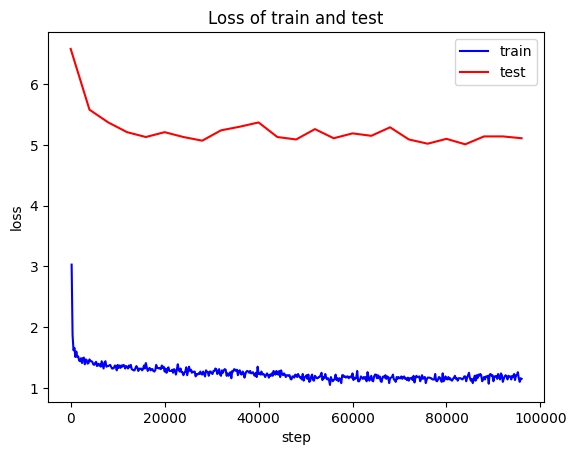

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
train_eva = pd.read_json("/content/new 2.json")
test_eva = pd.read_json("/content/new 1.json")
plt.plot(train_eva["step"],train_eva["loss"],label='train',color="blue")
plt.plot(test_eva["step"],test_eva['valid loss'],label='test',color="red")
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Loss of train and test')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

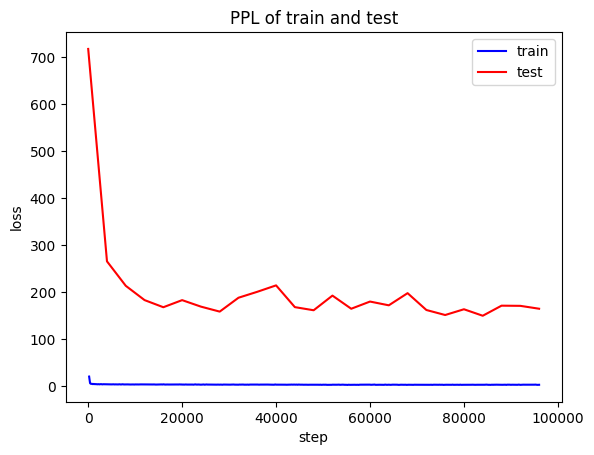

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
train_eva = pd.read_json("/content/new 2.json")
test_eva = pd.read_json("/content/new 1.json")
plt.plot(train_eva["step"],train_eva["ppl"],label='train',color="blue")
plt.plot(test_eva["step"],test_eva['valid ppl'],label='test',color="red")
plt.xlabel('step')
plt.ylabel('loss')
plt.title('PPL of train and test')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

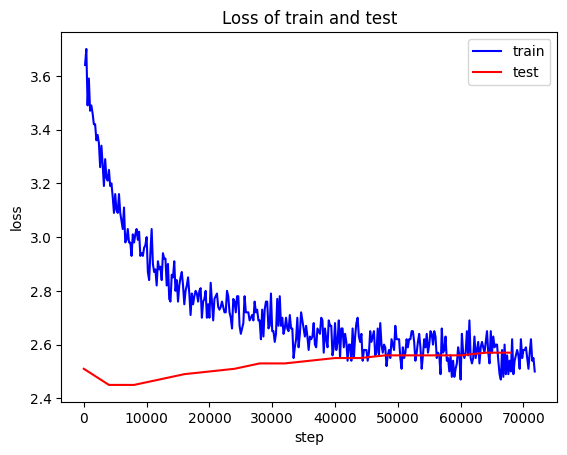

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
train_eva = pd.read_json("/content/train2.json")
test_eva = pd.read_json("/content/val2.json")
plt.plot(train_eva["step"],train_eva["loss"],label='train',color="blue")
plt.plot(test_eva["step"],test_eva['valid loss'],label='test',color="red")
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Loss of train and test')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

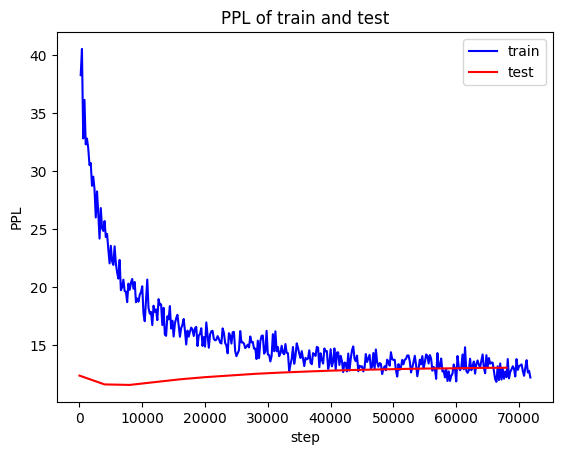

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
train_eva = pd.read_json("/content/train2.json")
test_eva = pd.read_json("/content/val2.json")
plt.plot(train_eva["step"],train_eva["ppl"],label='train',color="blue")
plt.plot(test_eva["step"],test_eva['valid ppl'],label='test',color="red")
plt.xlabel('step')
plt.ylabel('PPL')
plt.title('PPL of train and test')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

## Generate

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

def load_vocab(vocab_fp):
  idx2sym = ['<S>']
  wait_amts = []
  with open(vocab_fp, 'r') as f:
    for line in f:
      idx2sym.append(line.strip().split(',')[-1])
      if line[:2] == 'WT':
        wait_amts.append(int(line[3:]))
  sym2idx = {s:i for i, s in enumerate(idx2sym)}
  return idx2sym, sym2idx, wait_amts


def quantize_wait_event(wait_event):
  wait_time = int(wait_event[3:])
  diff = float('inf')
  candidate = None

  for t in wait_amts:
    cur_diff = abs(wait_time - t)
    if cur_diff < diff:
      diff = cur_diff
      candidate = t
    else:
      break
  return 'WT_{}'.format(candidate)


class TxlSimpleSampler:
  def __init__(self, model, device, tgt_len=1, mem_len=896, ext_len=0):
    if tgt_len != 1:
      raise ValueError()
    if ext_len != 0:
      raise ValueError()
    self.model = model
    self.model.eval()
    self.model.reset_length(1, ext_len, mem_len)
    self.device = device
    self.reset()


  def reset(self):
    self.mems = []
    self.generated = []


  @torch.no_grad()
  def sample_next_token_updating_mem(self, last_token=None, temp=1., topk=None, exclude_eos=True):
    last_token = last_token if last_token is not None else 0

    # Ensure that user is always passing 0 on first call
    if len(self.generated) == 0:
      assert len(self.mems) == 0
      if last_token != 0:
        raise Exception()

    # Ensure that user isn't passing 0 after first call
    if last_token == 0 and len(self.generated) > 0:
      raise Exception()

    # Sanitize sampling params
    if temp < 0:
      raise ValueError()
    if topk is not None and topk < 1:
      raise ValueError()

    # Append last input token because we've officially selected it
    self.generated.append(last_token)

    # Create input array
    _inp = [last_token]
    _inp = np.array(_inp, dtype=np.int64)[:, np.newaxis]
    inp = torch.from_numpy(_inp).to(self.device)

    # Evaluate the model, saving its memory.
    ret = self.model.forward_generate(inp, *self.mems)
    all_logits, self.mems = ret[0], ret[1:]

    # Select last timestep, only batch item
    logits = all_logits[-1, 0]

    if exclude_eos:
      logits = logits[1:]

    # Handle temp 0 (argmax) case
    if temp == 0:
      probs = torch.zeros_like(logits)
      probs[logits.argmax()] = 1.
    else:
      # Apply temperature spec
      if temp != 1:
        logits /= temp

      # Compute softmax
      probs = F.softmax(logits, dim=-1)

    if exclude_eos:
      probs = F.pad(probs, [0])

    # Select top-k if specified
    if topk is not None:
      _, top_idx = torch.topk(probs, topk)
      mask = torch.zeros_like(probs)
      mask[top_idx] = 1.
      probs *= mask
      probs /= probs.sum()

    # Sample from probabilities
    token = torch.multinomial(probs, 1)
    token = int(token.item())

    return token, probs

In [ ]:
if __name__ == '__main__':
  from argparse import ArgumentParser, Namespace
  import os
  import sys

  import torch

  # script_dir = os.path.dirname(os.path.abspath(__file__))
  # code_model_dir = os.path.abspath(os.path.join(script_dir, 'model'))
  # code_utils_dir = os.path.join(code_model_dir, 'utils')
  # sys.path.extend([code_model_dir, code_utils_dir])

  # from utils import TxlSimpleSampler, load_vocab

  args = Namespace(
      model_dir="/content/drive/MyDrive/model",
      tx1=True,
      out_dir='/content/out',
      gpu=False,
      num=1,
      mem_len=512,
      gen_len=1024,
      temp=0.95,
      topk=32
  )

  model_fp = os.path.join(args.model_dir, 'model.pt')
  vocab_fp = os.path.join(args.model_dir, 'vocab.txt')
  if not os.path.isdir(args.out_dir):
    os.makedirs(args.out_dir)
  ext = '.tx1.txt' if args.tx1 else '.tx2.txt'
  device = torch.device('cuda' if args.gpu else 'cpu')

  # Load the best saved model.
  with open(model_fp, 'rb') as f:
    model = torch.load(f,map_location=torch.device('cpu'))
  model.backward_compatible()
  model = model.to(device)

  # Make sure model uses vanilla softmax.
  if model.sample_softmax > 0:
    raise NotImplementedError()
  if model.crit.n_clusters != 0:
    raise NotImplementedError()

  # Load the vocab.
  idx2sym, _, _ = load_vocab(vocab_fp)

  # Generate.
  for i in range(args.num):
    out_fn = str(i) + ext
    out_fp = os.path.join(args.out_dir, out_fn)
    sampler = TxlSimpleSampler(model, device, mem_len=args.mem_len)
    seq = [0,2]
    sampler.generated.extend(seq)
    for _ in range(args.gen_len):
      token, _ = sampler.sample_next_token_updating_mem(
          seq[-1], temp=args.temp, topk=args.topk)
      seq.append(token)
    with open(out_fp, 'w') as f:
      f.write('\n'.join(idx2sym[t] for t in seq[1:]))

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=28054b36e197cd0a4a2fd39f2d1e19cd86ec5839210d56e3583fbd3e18ac7816
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
!pip install nes-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp311-cp311-linux_x86_64.whl size=535720 sha256=1ba5b8a5b90972be6f6c3030765bb9b257394e161711d31a2acfc9a1bf8e7c11
  Stored in directory: /root/.cache/pip/wheels/be/b4/5a/68b9155f1d2380af0e359c71efd4c70518555be4c2f577f1d3
Successfully built nes-py


In [ ]:
from collections import defaultdict
import tempfile
def tx1_to_midi(tx1):
  import pretty_midi

  tx1 = tx1.strip().splitlines()
  nsamps = sum([int(x.split('_')[1]) for x in tx1 if x[:2] == 'WT'])

  # Create MIDI instruments
  p1_prog = pretty_midi.instrument_name_to_program('Lead 1 (square)')
  p2_prog = pretty_midi.instrument_name_to_program('Lead 2 (sawtooth)')
  tr_prog = pretty_midi.instrument_name_to_program('Synth Bass 1')
  no_prog = pretty_midi.instrument_name_to_program('Breath Noise')
  p1 = pretty_midi.Instrument(program=p1_prog, name='p1', is_drum=False)
  p2 = pretty_midi.Instrument(program=p2_prog, name='p2', is_drum=False)
  tr = pretty_midi.Instrument(program=tr_prog, name='tr', is_drum=False)
  no = pretty_midi.Instrument(program=no_prog, name='no', is_drum=True)

  name_to_ins = {'P1': p1, 'P2': p2, 'TR': tr, 'NO': no}
  name_to_pitch = {'P1': None, 'P2': None, 'TR': None, 'NO': None}
  name_to_start = {'P1': None, 'P2': None, 'TR': None, 'NO': None}
  name_to_max_velocity = {'P1': 15, 'P2': 15, 'TR': 1, 'NO': 15}

  samp = 0
  for event in tx1:
    if event[:2] == 'WT':
      samp += int(event[3:])
    else:
      tokens = event.split('_')
      name = tokens[0]
      ins = name_to_ins[tokens[0]]

      old_pitch = name_to_pitch[name]
      if tokens[1] == 'NOTEON':
        if old_pitch is not None:
          ins.notes.append(pretty_midi.Note(
              velocity=name_to_max_velocity[name],
              pitch=old_pitch,
              start=name_to_start[name] / 44100.,
              end=samp / 44100.))
        name_to_pitch[name] = int(tokens[2])
        name_to_start[name] = samp
      else:
        if old_pitch is not None:
          ins.notes.append(pretty_midi.Note(
              velocity=name_to_max_velocity[name],
              pitch=name_to_pitch[name],
              start=name_to_start[name] / 44100.,
              end=samp / 44100.))

        name_to_pitch[name] = None
        name_to_start[name] = None

  # Deactivating this for generated files
  #for name, pitch in name_to_pitch.items():
  #  assert pitch is None

  # Create MIDI and add instruments
  midi = pretty_midi.PrettyMIDI(initial_tempo=120, resolution=22050)
  midi.instruments.extend([p1, p2, tr, no])

  # Create indicator for end of song
  eos = pretty_midi.TimeSignature(1, 1, nsamps / 44100.)
  midi.time_signature_changes.append(eos)

  with tempfile.NamedTemporaryFile('rb') as mf:
    midi.write(mf.name)
    midi = mf.read()

  return midi

In [ ]:
with open("/content/out/0.tx1.txt", 'r') as f:
  tx1 = f.read()
midi = tx1_to_midi(tx1)
with open("nes_song.mid", 'wb') as f:
  f.write(midi)


In [ ]:
import subprocess

def midi_to_wav(midi_file, sf2_file, wav_file):
    """Chuyển đổi MIDI thành WAV bằng FluidSynth"""
    command = [
        "fluidsynth", "-ni", sf2_file, midi_file, "-F", wav_file, "-r", "44100"
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Ví dụ sử dụng
midi_to_wav("nes_song.mid", "NES_Famicom.sf2", "output.wav")

In [ ]:
import nesmdb
from nesmdb.utils import wavwrite
def tx1_to_wav(tx1_fp, out_fp, midi_downsample_rate=None):
  if midi_downsample_rate == 0:
    midi_downsample_rate = None

  print('(Rate {}) {}->{}'.format(midi_downsample_rate, tx1_fp, out_fp))
  with open(tx1_fp, 'r') as f:
    tx1 = f.read()
  midi = tx1_to_midi(tx1)
  wav = nesmdb.convert.midi_to_wav(midi, midi_downsample_rate)
  wavwrite(out_fp, 44100, wav)
  print('Done: {}'.format(wav.shape))
  return True

In [ ]:
import pretty_midi
import soundfile as sf

def midi_to_wav(midi_file, sf2_file, wav_file):
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    # Convert MIDI to raw audio using SoundFont
    audio = midi_data.fluidsynth(sf2_path=sf2_file)

    # Save the WAV file
    sf.write(wav_file, audio, 44100)
# Ví dụ sử dụng
midi_to_wav("/content/nes_song.mid", "/content/Famicom.sf2", "output.wav")


In [ ]:
te_iter = corpus.get_iterator('train', eval_batch_size, args.eval_tgt_len,
    device=device, ext_len=args.ext_len)

In [ ]:
for i in te_iter:
  print(i)